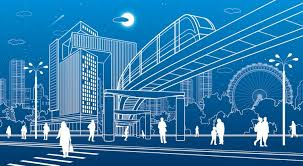 

<b> CASE STUDY DATASET - UK Road Safety Dataset</b>

This Jupyter notebook will set out the Business Objective, look at the Explorary Data Analysis (EDA) of the dataset along with data preprocessing. 

TABLE OF CONTENTS

1. Business Objective
2. Importing Libraries
3. Loading the dataset
4. Data Preparation and Feature Selection
5. Data Splitting
6. Explorary Data Analysis (EDA)
7. Handling Impute Values
8. Conclusion

## 1. Business Objective

Safety especially on the road is a paramount to all stakeholders. To ensure that the roads are safe for users, it is important to understand the factors that contribute to road accidents.

The aim is to build a model that predict the severity of accidents in the UK. The model will answer questions such as "What types of road lead to more accidents?" and "What kind of weather conditions are cars more susceptible to accidents?". This would allow Urban planners to corrobate safety of roads by examining what road types are more susceptible to accidents, Health and Safety responders would also be able to leverage on severity predictions to estimate the potential impacts of an accident and implement efficient response procedures.

The predictive model will use Accident Severity as the Dependent Variable and road type, junction detail, junction control, number of vehicles, lighting and weather conditions as the Independent Variables.

## 2. Importing Libraries

In [1]:
# General required libraries
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Libraries for visualisations.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries for data preprocessinng and cleaning.
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## 3. Loading the dataset
Here, we load the dataset from the [UK Government's official site](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data). We are using *dft-road-casualty-statistics-accident-2020.csv*. 
There are 36 columns and 91199 entries in the dataset. 

In [2]:
# Loads the dataset into a pandas DataFrame object and view its tail.

accidents_df = pd.read_csv('dft-road-casualty-statistics-accident-2020.csv', low_memory=False)
accidents_df.tail()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
91194,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,0,1,1,1,0,0,1,1,-1,-1
91195,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,0,1,1,1,0,0,1,2,-1,-1
91196,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,0,1,1,1,0,0,2,1,-1,-1
91197,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,0,1,1,1,0,0,1,2,-1,-1
91198,2020991032575,2020,991032575,240402.0,681950.0,-4.561040,56.003843,99,3,1,...,0,1,1,1,0,2,1,1,-1,-1


In [3]:
# Verify the shape of the DataFrame

accidents_df.shape

(91199, 36)

## 4. Data Preparation and Feature Selection
In this step, we prepare the data to be modelled and retain only the columns which we deem necessary. 
The following 11 columns are picked and retained for future modelling:
*road_type*, *junction_detail*, *junction_control*, *light_conditions*, *weather_conditions*, *road_surface_conditions*, *time*, *number_of_vehicles*, *number_of_casualties*, *day_of_week*, *accident_severity*. 

In [4]:
# Select columns of interest and delete the rest for convenience.

cols_of_interest = ['road_type', 'junction_detail', 'junction_control', \
                    'light_conditions', 'weather_conditions', 'road_surface_conditions',\
                    'time', 'number_of_vehicles', 'number_of_casualties', 'day_of_week',\
                   'accident_severity']

for col in accidents_df.columns:
    if col not in cols_of_interest:
        del accidents_df[col]

In [5]:
# Examine the dataframe.

accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,3,1,1,3,09:00,6,0,-1,1,9,9
1,3,1,2,2,13:55,6,9,2,1,1,1
2,3,1,1,4,01:25,6,3,1,4,1,2
3,2,1,1,4,01:50,6,0,-1,4,1,1
4,3,1,2,4,02:25,6,3,4,4,1,1


In [6]:
# Inspects the new shape of the DataFrame.

accidents_df.shape

(91199, 11)

In order to prepare the data, we convert the data types of the selected columns to the correct ones. For instance, time is converted to the datetime object. Meanwhile, the categorical variables are converted from *int* to *object* type where they contain the nominal values. 

In [7]:
# Display the data types of the selected columns (variables)

accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   accident_severity        91199 non-null  int64 
 1   number_of_vehicles       91199 non-null  int64 
 2   number_of_casualties     91199 non-null  int64 
 3   day_of_week              91199 non-null  int64 
 4   time                     91199 non-null  object
 5   road_type                91199 non-null  int64 
 6   junction_detail          91199 non-null  int64 
 7   junction_control         91199 non-null  int64 
 8   light_conditions         91199 non-null  int64 
 9   weather_conditions       91199 non-null  int64 
 10  road_surface_conditions  91199 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 7.7+ MB


In [8]:
# Convert the time of the accident into the correct data type.

accidents_df['time'] = pd.to_datetime(accidents_df['time'], format="%H:%M")

In [9]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_severity        91199 non-null  int64         
 1   number_of_vehicles       91199 non-null  int64         
 2   number_of_casualties     91199 non-null  int64         
 3   day_of_week              91199 non-null  int64         
 4   time                     91199 non-null  datetime64[ns]
 5   road_type                91199 non-null  int64         
 6   junction_detail          91199 non-null  int64         
 7   junction_control         91199 non-null  int64         
 8   light_conditions         91199 non-null  int64         
 9   weather_conditions       91199 non-null  int64         
 10  road_surface_conditions  91199 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 7.7 MB


In [10]:
# Replace the accident severity column with the actual nominal values.

accident_dict = {

1 : "Fatal",
2 : "Serious",
3 : "Slight"
}

accidents_df['accident_severity'] = accidents_df['accident_severity'].map(accident_dict)

In [11]:
# Replace Days of the week column with actual nominal values to reflect their true datatype.

days_dict = {
    1 : 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

accidents_df['day_of_week'] = accidents_df['day_of_week'].map(days_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,6,0,-1,1,9,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,6,9,2,1,1,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,6,3,1,4,1,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,6,0,-1,4,1,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,6,3,4,4,1,1


In [12]:
road_type_dict = {
    1 : 'Roundabout',
    2 : 'One way street',
    3 : 'Dual carriageway',
    6 : 'Single carriageway',
    7 : 'Slip road',
    9 : 'Unknown',
    12 : 'One way street/Slip road',
    -1 : 'Data missing or out of range'
}

accidents_df['road_type'] = accidents_df['road_type'].map(road_type_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,0,-1,1,9,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,9,2,1,1,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,3,1,4,1,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,0,-1,4,1,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,3,4,4,1,1


In [13]:
junction_dict = {
    0 : 'Not at junction or within 20 metres',
    1 : 'Roundabout',
    2 : 'Mini-roundabout',
    3 : 'T or staggered junction',
    5 : 'Slip road',
    6 : 'Crossroads',
    7 : 'More than 4 arms (not roundabout)',
    8 : 'Private drive or entrance',
    9 : 'Other junction',
    99 : 'unknown (self reported)',
    -1 : 'Data missing or out of range'
}

accidents_df['junction_detail'] = accidents_df['junction_detail'].map(junction_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,Not at junction or within 20 metres,-1,1,9,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,Other junction,2,1,1,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,T or staggered junction,1,4,1,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,Not at junction or within 20 metres,-1,4,1,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,T or staggered junction,4,4,1,1


In [14]:
junction_control_dict = {
    0 : 'Not at junction or within 20 metres',
    1 : 'Authorised person',
    2 : 'Auto traffic signal',
    3 : 'Stop sign',
    4 : 'Give way or uncontrolled',
    -1 : 'Data missing or out of range',
    9 : 'unknown (self reported)'
}

accidents_df['junction_control'] = accidents_df['junction_control'].map(junction_control_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,1,9,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,Other junction,Auto traffic signal,1,1,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,T or staggered junction,Authorised person,4,1,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,4,1,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,T or staggered junction,Give way or uncontrolled,4,1,1


In [15]:
light_conditions_dict = {
    1 : 'Daylight',
    4 : 'Darkness - lights lit',
    5 : 'Darkness - lights unlit', 
    6 : 'Darkness - no lighting',
    7 : 'Darkness - lighting unknown',
    -1 : 'Data missing or out of range'
}

accidents_df['light_conditions'] = accidents_df['light_conditions'].map(light_conditions_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,Daylight,9,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,Other junction,Auto traffic signal,Daylight,1,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,T or staggered junction,Authorised person,Darkness - lights lit,1,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,Darkness - lights lit,1,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,T or staggered junction,Give way or uncontrolled,Darkness - lights lit,1,1


In [16]:
weather_dict = {
    1: "Fine no high winds",
    2: "Raining no high winds",
    3: "Snowing no high winds",
    4: "Fine + high winds",
    5: "Raining + high winds",
    6: "Snowing + high winds",
    7: "Fog or mist",
    8: "Other",
    9: "Unknown",
    -1: "Data missing or out of range"
}

accidents_df['weather_conditions'] = accidents_df['weather_conditions'].map(weather_dict)
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,Daylight,Unknown,9
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,Other junction,Auto traffic signal,Daylight,Fine no high winds,1
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,T or staggered junction,Authorised person,Darkness - lights lit,Fine no high winds,2
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,Not at junction or within 20 metres,Data missing or out of range,Darkness - lights lit,Fine no high winds,1
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,T or staggered junction,Give way or uncontrolled,Darkness - lights lit,Fine no high winds,1


In [17]:
road_conditions_dict = {
    1 : 'Dry',
    2 : 'Wet or damp',
    3 : 'Snow',
    4 : 'Frost or ice',
    5 : 'Flood over 3cm. deep',
    6 : 'Oil or diesel',
    7 : 'Mud',
    -1 : 'Data missing or out of range',
    9 : 'unknown (self reported)'
}

accidents_df['road_surface_conditions'] = accidents_df['road_surface_conditions'].map(road_conditions_dict)
accidents_df.head()
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_severity        91199 non-null  object        
 1   number_of_vehicles       91199 non-null  int64         
 2   number_of_casualties     91199 non-null  int64         
 3   day_of_week              91199 non-null  object        
 4   time                     91199 non-null  datetime64[ns]
 5   road_type                91199 non-null  object        
 6   junction_detail          91199 non-null  object        
 7   junction_control         91199 non-null  object        
 8   light_conditions         91199 non-null  object        
 9   weather_conditions       91199 non-null  object        
 10  road_surface_conditions  91199 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 7.7+ MB


In [18]:
# Replace "Unknown" and "Data missing or out of range" with NaN, 
# so later on we can deal with them as missing values.

cols_to_replace = ['light_conditions', 'junction_control', 'road_surface_conditions', \
                   'weather_conditions', 'road_type', 'junction_detail']
accidents_df[cols_to_replace] = accidents_df[cols_to_replace].replace({'Data missing or out of range' :  np.NaN, 
                                                                       'unknown (self reported)' : np.NaN, 
                                                                       'Unknown' : np.NaN, 
                                                                       'Darkness - lighting unknown' : np.NaN})
accidents_df.head()

,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,time,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions
0,Slight,1,1,Tuesday,1900-01-01 09:00:00,Single carriageway,Not at junction or within 20 metres,NaN,Daylight,NaN,NaN
1,Slight,1,2,Monday,1900-01-01 13:55:00,Single carriageway,Other junction,Auto traffic signal,Daylight,Fine no high winds,Dry
2,Slight,1,1,Wednesday,1900-01-01 01:25:00,Single carriageway,T or staggered junction,Authorised person,Darkness - lights lit,Fine no high winds,Wet or damp
3,Serious,1,1,Wednesday,1900-01-01 01:50:00,Single carriageway,Not at junction or within 20 metres,NaN,Darkness - lights lit,Fine no high winds,Dry
4,Slight,1,2,Wednesday,1900-01-01 02:25:00,Single carriageway,T or staggered junction,Give way or uncontrolled,Darkness - lights lit,Fine no high winds,Dry


In [19]:
# Check for null (missing/unknown) values.

accidents_df.isnull().sum()

accident_severity              0
number_of_vehicles             0
number_of_casualties           0
day_of_week                    0
time                           0
road_type                   2006
junction_detail             1510
junction_control           39834
light_conditions            2195
weather_conditions          2424
road_surface_conditions     1163
dtype: int64

## 5. Data Splitting
Since we're dealing with a large dataset, we will randomly split the dataset into training and testing sets with a specified random state equivalent to the year under review. This is to ensure that we have the same data in both sets everytime we run the code.

In [20]:
# Train-Test split

train_set, test_set = train_test_split(accidents_df, test_size=0.2, random_state=2020)
print(f"Data split into {train_set.shape[0]} train and {test_set.shape[0]} test instances.")

Data split into 72959 train and 18240 test instances.


In [21]:
# Examine the shapes of the dataframes.

print(train_set.shape)
print(test_set.shape)

(72959, 11)
(18240, 11)


## 6. Explorary Data Analysis (EDA) on Training Datasets

We can inspect the columns in the dataset and their data types by displaying critical information.

In [22]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72959 entries, 63814 to 41824
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_severity        72959 non-null  object        
 1   number_of_vehicles       72959 non-null  int64         
 2   number_of_casualties     72959 non-null  int64         
 3   day_of_week              72959 non-null  object        
 4   time                     72959 non-null  datetime64[ns]
 5   road_type                71353 non-null  object        
 6   junction_detail          71728 non-null  object        
 7   junction_control         41151 non-null  object        
 8   light_conditions         71188 non-null  object        
 9   weather_conditions       70986 non-null  object        
 10  road_surface_conditions  72016 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 6.7+ MB


The data types are majorly categorical/object except the number of vehicles and casualties which are numerical (int64) and the time of the accident which is a date time object.

### Dependent variable

The chosen dependent variable is the *accident severity* and we can inspect the distribution by displaying the number of values and showing a bar chart of this distribution.

In [23]:
pd.DataFrame(train_set.loc[:,'accident_severity'].describe())

,accident_severity
count,72959
unique,3
top,Slight
freq,57220


We can now inspect the number of values and the percentage distribution.

In [24]:
# Display unique values of the accident severity.
train_set['accident_severity'].value_counts()
severity = pd.DataFrame(train_set.loc[:,'accident_severity'].value_counts())
severity.columns = ['Severity']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'accident_severity'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
severity.join(percentages)

,Severity,% Distribution
Slight,57220,78.43%
Serious,14606,20.02%
Fatal,1133,1.55%


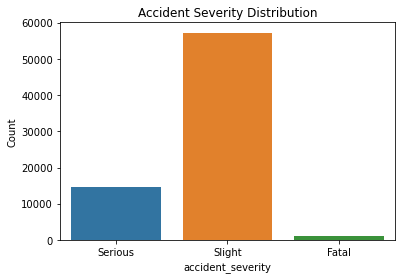

In [25]:
severity_count = sns.countplot(train_set.loc[:,'accident_severity'])
#Setting graph title
severity_count.set_title('Accident Severity Distribution')
severity_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()

### Numerical Independent Variables

The numerical independent variables are located in the columns:

1. number_of_vehicles
2. number_of_casualties
3. time

<h4> Number of vehicles </h4>

We display descriptive statistics and visualise the distribution on a histogram and boxplot.

In [26]:
pd.DataFrame(train_set.loc[:,'number_of_vehicles'].describe())

,number_of_vehicles
count,72959.000000
mean,1.837210
std,0.679352
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,13.000000


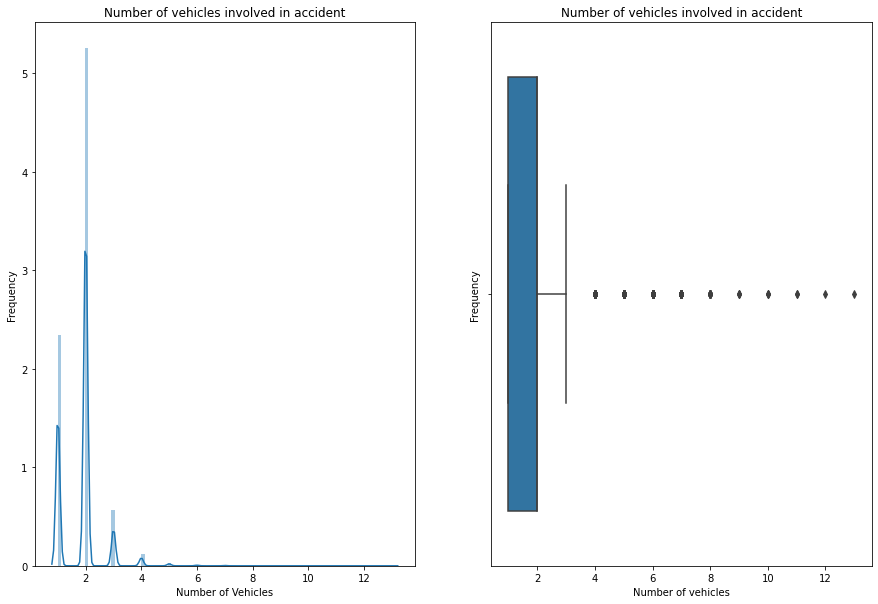

In [27]:
chart = plt.figure(figsize = (15,10))

#Histogram
plt.subplot(1,2,1)
hist = sns.distplot(train_set.loc[:,'number_of_vehicles'].astype(int), bins = 100)

#Setting graph title
hist.set_title('Number of vehicles involved in accident')
hist.set(xlabel = 'Number of Vehicles', ylabel = 'Frequency')

#Boxplot
plt.subplot(1,2,2)
box = sns.boxplot(train_set.loc[:,'number_of_vehicles'].astype(int))

#Setting graph title
box.set_title('Number of vehicles involved in accident')
box.set(xlabel = 'Number of vehicles', ylabel = 'Frequency')

#Showing the plot
plt.show()

<h4> Number of Casualties </h4>

In [28]:
pd.DataFrame(train_set.loc[:,'number_of_casualties'].describe())

,number_of_casualties
count,72959.00000
mean,1.26848
std,0.68729
min,1.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,41.00000


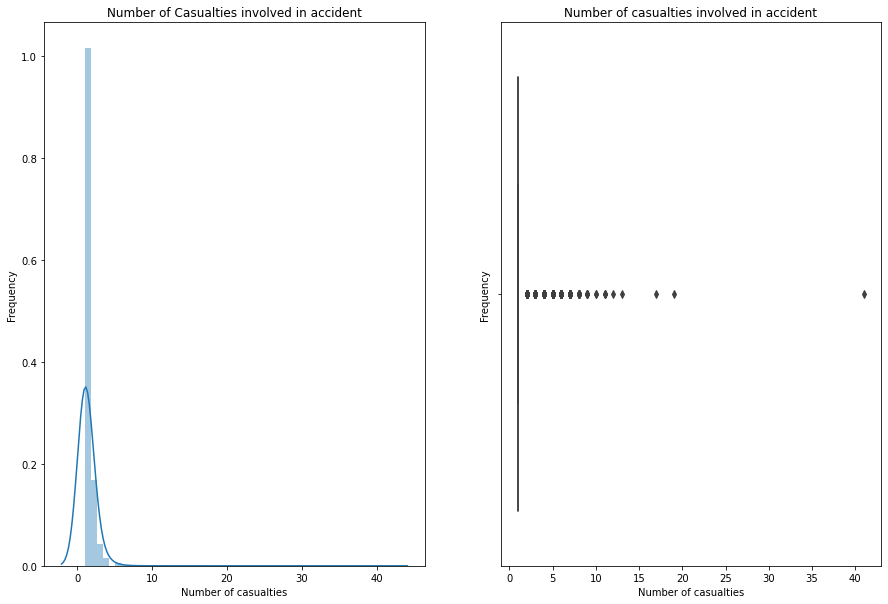

In [29]:
chart = plt.figure(figsize = (15,10))

#Histogram
plt.subplot(1,2,1)
hist = sns.distplot(train_set.loc[:,'number_of_casualties'].astype(int), bins = 50, kde_kws = {'bw' : 1.5})

#Setting graph title
hist.set_title('Number of Casualties involved in accident')
hist.set(xlabel = 'Number of casualties', ylabel = 'Frequency')

#Boxplot
plt.subplot(1,2,2)
box = sns.boxplot(train_set.loc[:,'number_of_casualties'].astype(int))

#Setting graph title
box.set_title('Number of casualties involved in accident')
box.set(xlabel = 'Number of casualties', ylabel = 'Frequency')

#Showing the plot
plt.show()

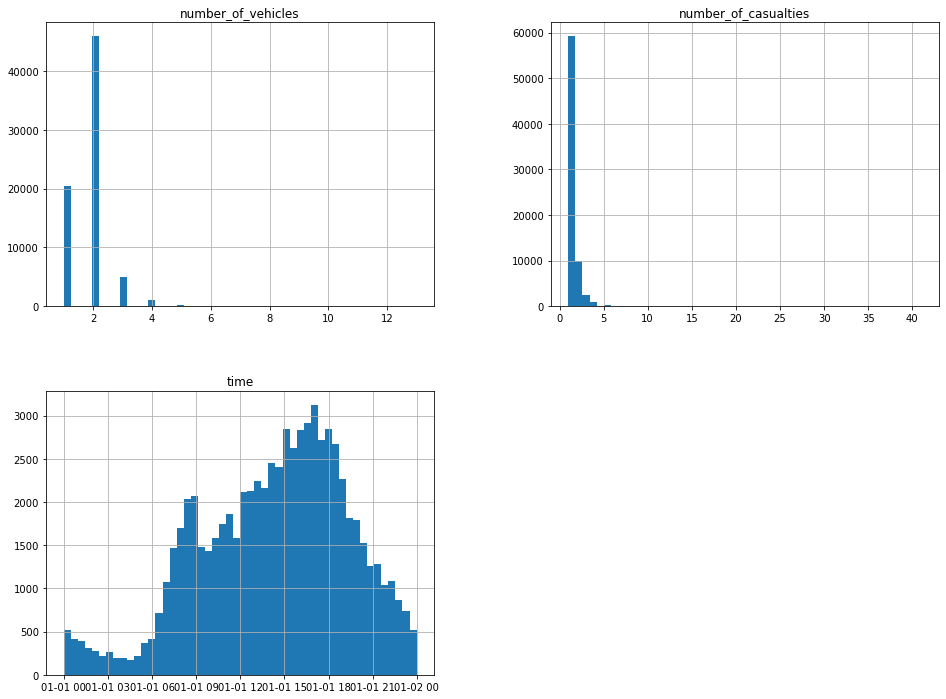

In [30]:
numericals = train_set.hist(bins=50, figsize=(16,12))

### Categorical Independent Variables

The categorical independent variables are located in the columns:

1. road_type
2. junction_detail
3. junction_control 
4. light_conditions
5. weather_conditions
6. road_surface_conditions
7. day_of_week

<b> Road Type </b>

In [31]:
pd.DataFrame(train_set.loc[:,'road_type'].describe())

,road_type
count,71353
unique,5
top,Single carriageway
freq,53477


In [32]:
# Display unique values of the road type.
train_set['road_type'].value_counts()
severity = pd.DataFrame(train_set.loc[:,'road_type'].value_counts())
severity.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'road_type'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
severity.join(percentages)

,Count,% Distribution
Single carriageway,53477,74.95%
Dual carriageway,10605,14.86%
Roundabout,4508,6.32%
One way street,1559,2.18%
Slip road,1204,1.69%


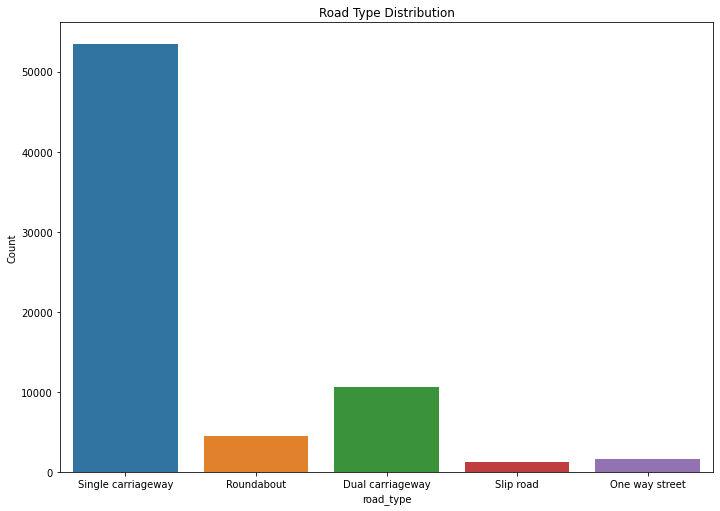

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

road_count = sns.countplot(train_set.loc[:,'road_type'], ax=ax)
#Setting graph title
road_count.set_title('Road Type Distribution')
road_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()

<b> Junction Detail </b>

In [34]:
pd.DataFrame(train_set.loc[:,'junction_detail'].describe())

,junction_detail
count,71728
unique,9
top,Not at junction or within 20 metres
freq,30295


In [35]:
# Display unique values of the junction detail.
train_set['junction_detail'].value_counts()
detail = pd.DataFrame(train_set.loc[:,'junction_detail'].value_counts())
detail.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'junction_detail'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
detail.join(percentages)

,Count,% Distribution
Not at junction or within 20 metres,30295,42.24%
T or staggered junction,20493,28.57%
Crossroads,6737,9.39%
Roundabout,5907,8.24%
Other junction,3763,5.25%
Private drive or entrance,1528,2.13%
Mini-roundabout,1053,1.47%
More than 4 arms (not roundabout),1014,1.41%
Slip road,938,1.31%


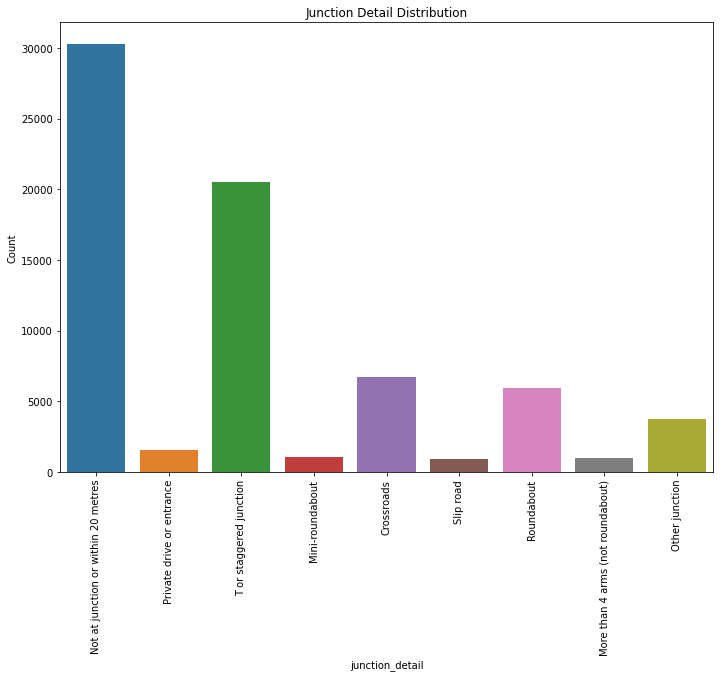

In [36]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

road_count = sns.countplot(train_set.loc[:,'junction_detail'], ax=ax)
#Setting graph title
road_count.set_title('Junction Detail Distribution')
road_count.set(ylabel = 'Count')
plt.xticks(rotation=90)
#Showing the plot
plt.show()

<b> Junction Control </b>

In [37]:
pd.DataFrame(train_set.loc[:,'junction_control'].describe())

,junction_control
count,41151
unique,4
top,Give way or uncontrolled
freq,32052


In [38]:
# Display unique values of the junction detail.
train_set['junction_control'].value_counts()
control = pd.DataFrame(train_set.loc[:,'junction_control'].value_counts())
control.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'junction_control'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
control.join(percentages)


,Count,% Distribution
Give way or uncontrolled,32052,77.89%
Auto traffic signal,8312,20.2%
Stop sign,483,1.17%
Authorised person,304,0.74%


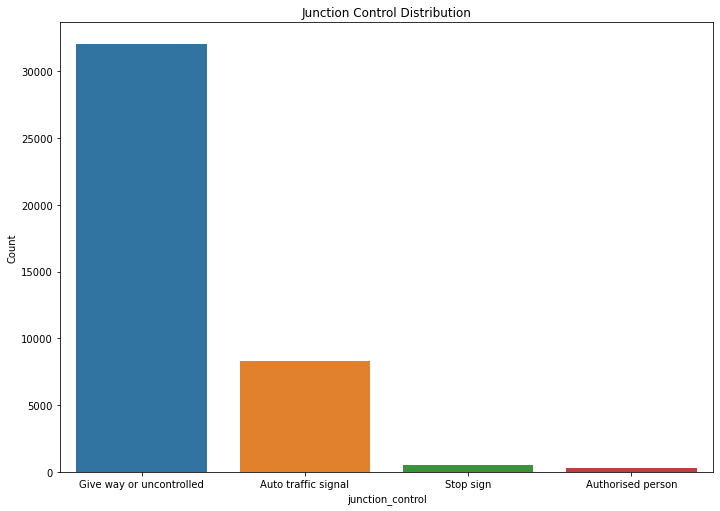

In [39]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

control_count = sns.countplot(train_set.loc[:,'junction_control'], ax=ax)
#Setting graph title
control_count.set_title('Junction Control Distribution')
control_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()

<b> Light Conditions </b>

In [40]:
pd.DataFrame(train_set.loc[:,'light_conditions'].describe())


,light_conditions
count,71188
unique,4
top,Daylight
freq,51671


In [41]:
# Display unique values of the junction detail.
train_set['light_conditions'].value_counts()
light = pd.DataFrame(train_set.loc[:,'light_conditions'].value_counts())
light.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'light_conditions'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
light.join(percentages)

,Count,% Distribution
Daylight,51671,72.58%
Darkness - lights lit,15108,21.22%
Darkness - no lighting,3865,5.43%
Darkness - lights unlit,544,0.76%


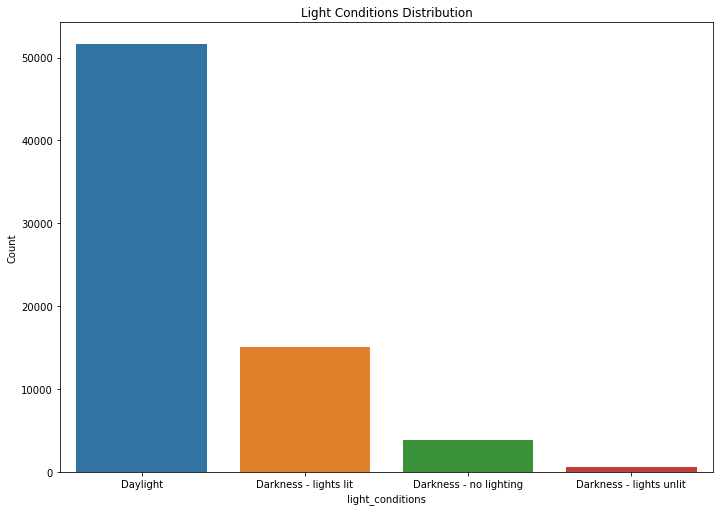

In [42]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

light_count = sns.countplot(train_set.loc[:,'light_conditions'], ax=ax)
#Setting graph title
light_count.set_title('Light Conditions Distribution')
light_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()

<b> Weather Conditions </b>

In [43]:
pd.DataFrame(train_set.loc[:,'weather_conditions'].describe())

,weather_conditions
count,70986
unique,8
top,Fine no high winds
freq,56542


In [44]:
# Display unique values of the junction detail.
train_set['weather_conditions'].value_counts()
weather = pd.DataFrame(train_set.loc[:,'weather_conditions'].value_counts())
weather.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'weather_conditions'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
weather.join(percentages)

,Count,% Distribution
Fine no high winds,56542,79.65%
Raining no high winds,9253,13.03%
Other,2123,2.99%
Raining + high winds,1329,1.87%
Fine + high winds,1124,1.58%
Fog or mist,408,0.57%
Snowing no high winds,143,0.2%
Snowing + high winds,64,0.09%


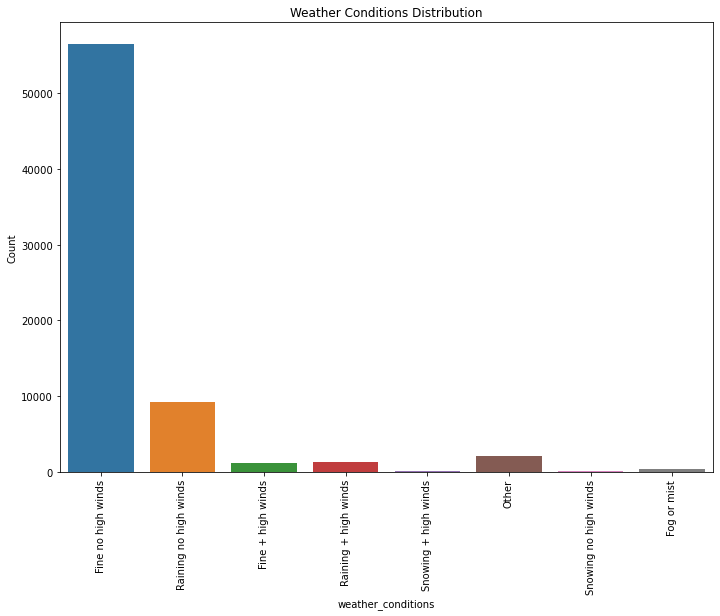

In [45]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

weather_count = sns.countplot(train_set.loc[:,'weather_conditions'], ax=ax)
#Setting graph title
weather_count.set_title('Weather Conditions Distribution')
weather_count.set(ylabel = 'Count')
plt.xticks(rotation=90)
#Showing the plot
plt.show()

<b> Road Surface Conditions </b>

In [46]:
pd.DataFrame(train_set.loc[:,'road_surface_conditions'].describe())

,road_surface_conditions
count,72016
unique,5
top,Dry
freq,50162


In [47]:
# Display unique values of the junction detail.
train_set['road_surface_conditions'].value_counts()
road_conditions = pd.DataFrame(train_set.loc[:,'road_surface_conditions'].value_counts())
road_conditions.columns = ['Count']


# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'road_surface_conditions'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
road_conditions.join(percentages)

,Count,% Distribution
Dry,50162,69.65%
Wet or damp,20971,29.12%
Frost or ice,615,0.85%
Flood over 3cm. deep,152,0.21%
Snow,116,0.16%


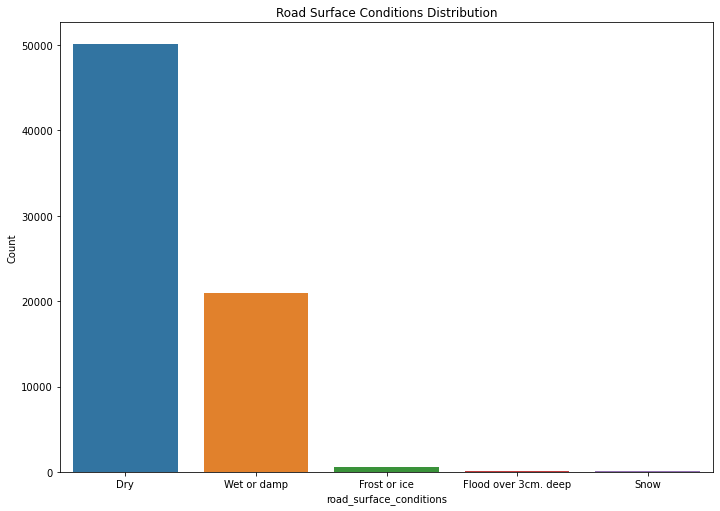

In [48]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

road_conditions_count = sns.countplot(train_set.loc[:,'road_surface_conditions'], ax=ax)
#Setting graph title
road_conditions_count.set_title('Road Surface Conditions Distribution')
road_conditions_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()


<b> Day of the Week </b>

In [49]:
pd.DataFrame(train_set.loc[:,'day_of_week'].describe())

,day_of_week
count,72959
unique,7
top,Friday
freq,11878


In [50]:
# Display unique values of the junction detail.
train_set['day_of_week'].value_counts()
day_week = pd.DataFrame(train_set.loc[:,'day_of_week'].value_counts())
day_week.columns = ['Count']

# Normalize the values to display as a percentage proportion of the whole.
percentages = pd.DataFrame(round(train_set.loc[:,'day_of_week'].value_counts(normalize=True)*100,2).map(lambda x : str(x)+'%'))
percentages.columns = ['% Distribution']
day_week.join(percentages)

,Count,% Distribution
Friday,11878,16.28%
Thursday,11232,15.39%
Wednesday,10881,14.91%
Tuesday,10580,14.5%
Monday,10207,13.99%
Saturday,9907,13.58%
Sunday,8274,11.34%


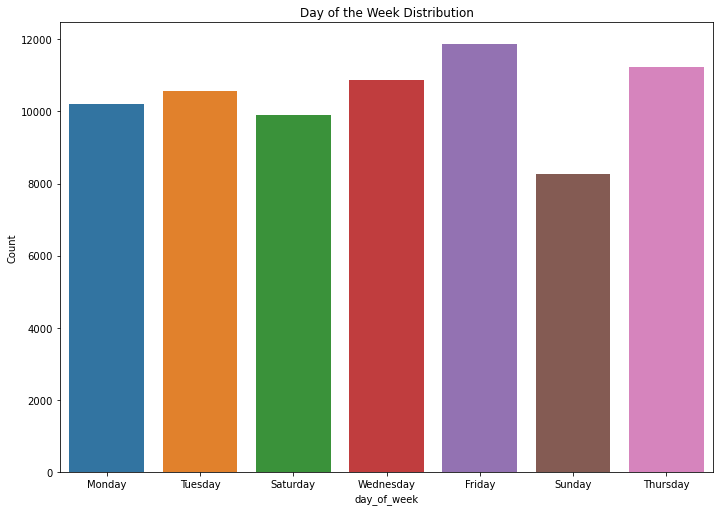

In [51]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

day_of_week_count = sns.countplot(train_set.loc[:,'day_of_week'], ax=ax)
#Setting graph title
day_of_week_count.set_title('Day of the Week Distribution')
day_of_week_count.set(ylabel = 'Count')
plt.xticks(rotation=0)
#Showing the plot
plt.show()

## 7. Data Preprocessing

In [52]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72959 entries, 63814 to 41824
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_severity        72959 non-null  object        
 1   number_of_vehicles       72959 non-null  int64         
 2   number_of_casualties     72959 non-null  int64         
 3   day_of_week              72959 non-null  object        
 4   time                     72959 non-null  datetime64[ns]
 5   road_type                71353 non-null  object        
 6   junction_detail          71728 non-null  object        
 7   junction_control         41151 non-null  object        
 8   light_conditions         71188 non-null  object        
 9   weather_conditions       70986 non-null  object        
 10  road_surface_conditions  72016 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 8.7+ MB


In [53]:
class OutlierHandler(TransformerMixin, BaseEstimator):

    """This class transforms all outliers into np.NaN that will be subsequently treated.
    Outliers < Q1-(1.5*IQR_Value) or > Q3+(1.5*IQR_Value)
    Note : the fit_transform method is inherited from the TransformerMixin super class
    """

    
    def __init__(self):
        self.fitted = False
        return None

    def fit(self, df):
        """
        Pre-condition: Unfitted DataFrame Object containing numerical outliers.
        Post-condition: Fitted DataFrame object with outliers transformed into null values.
        """
    # Select and handle outliers for only the columns containing numerical variables
        num_df = df.select_dtypes(include='int64')
        
    # Obtain values for Q1, Q3 and IQR ≡ Q3-Q1
        self.quantiles = pd.DataFrame(num_df.quantile([0.25, 0.75]))
        self.quantiles.loc['IQR',:] = self.quantiles.loc[0.75,:] - self.quantiles.loc[0.25,:]

    # Calculate upper and lower limits for outliers.
    # These bounds are calculated on the Train Dataset, then applied to the train and test datasets
        self.quantiles.loc['lower_limit',:] = self.quantiles.loc[0.25,:] - 1.5 * self.quantiles.loc['IQR',:]
        self.quantiles.loc['upper_limit',:] = self.quantiles.loc[0.75,:] + 1.5 * self.quantiles.loc['IQR',:]
    # Change fitting status
        self.fitted = True
        return self

    def transform(self, df):
        """
        Pre-condition: Fitted DataFrame object
        Post-condition: DataFrame object with outliers transformed into NaN.
        """
        if self.fitted == False:
            print('The transformer must be fitted before transformation.')
            return None
    # Make a copy of the dataframe object to prevent mutation.
        df_copy = df.copy()
    # Old number of NaNs to count number of outliers
        old_num_na = sum(df_copy.isnull().sum())
        for col in self.quantiles.columns:
    # Fill values < lower limit
            df_copy.loc[df_copy.loc[:,col] < self.quantiles.loc['lower_limit',col],col] = np.NaN
    # Fill values > upper limit
            df_copy.loc[df_copy.loc[:,col] > self.quantiles.loc['upper_limit',col],col] = np.NaN
    # Print Number of Outliers
        print(str(sum(df_copy.isna().sum()) - old_num_na) + ' Outliers are Identified.')
        return df_copy

In [54]:
outlier_handler = OutlierHandler()
new_train = outlier_handler.fit_transform(train_set)
new_test = outlier_handler.fit_transform(test_set)

15144 Outliers are Identified.
3730 Outliers are Identified.


In [55]:
def missing_values_handler(df):
    # Instantiate the simple imputer class to fill categorical and numerical variables.
    numerical_imputer = SimpleImputer(strategy="median")
    categorical_imputer = SimpleImputer(strategy="most_frequent")
    # Split the DataFrame object into numerical and categorical columns.
    df_numerical = df.select_dtypes(include='int64')
    df_categorical = df.select_dtypes(include='object')
    numerical_transformed = numerical_imputer.fit_transform(df_numerical)
    categorical_transformed = categorical_imputer.fit_transform(df_categorical)
    clean_df_categorical = pd.DataFrame(categorical_transformed, columns=df_categorical.columns)
    clean_df_numerical = pd.DataFrame(numerical_transformed, columns=df_numerical.columns)
    clean_df = clean_df_categorical.join(clean_df_numerical)
    return clean_df

In [56]:
train_set = missing_values_handler(train_set)
test_set = missing_values_handler(test_set)

In [57]:
train_set.isna().sum()

accident_severity          0
day_of_week                0
road_type                  0
junction_detail            0
junction_control           0
light_conditions           0
weather_conditions         0
road_surface_conditions    0
number_of_vehicles         0
number_of_casualties       0
dtype: int64

In [58]:
def get_dummies(train_set, test_set, old_col_name):
    """Given a train_set, a test_set, and the name of a column holding a 
    categorical variable, fit an encoder on the train_set, and use the 
    encoder to add dummy columns into the train_set and test_set
    """
    
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    cat_vals = train_set[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **train_set**
    
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the train_set dataframe
        train_set[new_col_name] = transformed[:,i]
    
    # transform the **test_set** using the fitted encoder
    
    cat_vals = test_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)

    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the train_set dataframe
        test_set[new_col_name] = transformed[:,i]
    
    return train_set, test_set

cat_list = ["road_type", "junction_detail", "junction_control", "light_conditions",\
            "weather_conditions", "road_surface_conditions", "day_of_week"]
for col_name in cat_list:
    train_set, test_set = get_dummies(train_set, test_set, col_name)

# check if the dummies are produced correctly in the train_set
train_set.head()

,accident_severity,day_of_week,road_type,junction_detail,junction_control,light_conditions,weather_conditions,road_surface_conditions,number_of_vehicles,number_of_casualties,...,Flood over 3cm. deep,Frost or ice,Snow,Wet or damp,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,Serious,Monday,Single carriageway,Not at junction or within 20 metres,Give way or uncontrolled,Daylight,Fine no high winds,Dry,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Slight,Tuesday,Single carriageway,Private drive or entrance,Give way or uncontrolled,Daylight,Fine no high winds,Dry,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Slight,Tuesday,Single carriageway,Private drive or entrance,Give way or uncontrolled,Daylight,Fine no high winds,Wet or damp,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Slight,Saturday,Single carriageway,Not at junction or within 20 metres,Give way or uncontrolled,Daylight,Fine no high winds,Dry,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Serious,Tuesday,Single carriageway,T or staggered junction,Give way or uncontrolled,Daylight,Fine no high winds,Dry,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
train_set.drop(columns=cat_list, inplace=True)
test_set.drop(columns=cat_list, inplace=True)

In [60]:
scaler = StandardScaler()

# take the target variable out before scaling
trainset_target = train_set["accident_severity"].values
trainset_predictors = train_set.drop("accident_severity", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(trainset_predictors)
train_set = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
train_set['accident_severity'] = trainset_target

# inspect the data
train_set.head()

,number_of_vehicles,number_of_casualties,One way street,Roundabout,Single carriageway,Slip road,Mini-roundabout,More than 4 arms (not roundabout),Not at junction or within 20 metres,Other junction,...,Frost or ice,Snow,Wet or damp,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,accident_severity
0,-1.232373,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,1.146407,-0.233199,...,-0.092201,-0.039906,-0.635123,2.479504,-0.396389,-0.357648,-0.426571,-0.411835,-0.418664,Serious
1,1.711627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Slight
2,0.239627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,1.574498,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Slight
3,-1.232373,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,1.146407,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,2.522774,-0.357648,-0.426571,-0.411835,-0.418664,Slight
4,0.239627,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Serious


In [61]:
testset_target = test_set["accident_severity"].values
testset_predictors = test_set.drop("accident_severity", axis=1)

scaled_vals = scaler.transform(testset_predictors)
test_set = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled target back in
test_set['accident_severity'] = testset_target

test_set.head()

,number_of_vehicles,number_of_casualties,One way street,Roundabout,Single carriageway,Slip road,Mini-roundabout,More than 4 arms (not roundabout),Not at junction or within 20 metres,Other junction,...,Frost or ice,Snow,Wet or damp,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,accident_severity
0,0.239627,1.064362,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,2.796044,-0.426571,-0.411835,-0.418664,Slight
1,0.239627,1.064362,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,2.479504,-0.396389,-0.357648,-0.426571,-0.411835,-0.418664,Slight
2,-1.232373,-0.390638,6.767465,-0.296809,-1.755390,-0.114123,-0.121013,-0.118719,1.146407,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,2.428155,-0.418664,Slight
3,0.239627,1.064362,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,-0.233199,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,2.796044,-0.426571,-0.411835,-0.418664,Slight
4,-1.232373,-0.390638,-0.147766,-0.296809,0.569674,-0.114123,-0.121013,-0.118719,-0.872291,4.288184,...,-0.092201,-0.039906,-0.635123,-0.403307,-0.396389,-0.357648,-0.426571,-0.411835,2.388551,Slight


## Data Exporting

In [62]:
train_set.to_csv('trainset.csv')
test_set.to_csv('testset.csv')